# Predicting the Price of a Home in Ames, Iowa

##  Problem Statement

[Home appraisals](https://www.investopedia.com/articles/pf/12/home-appraisals.asp) are almost always used in home purchase and sale transactions as well as in mortgage refinancing. Appraisers within a given financial institution will utilize the same [checklist](https://www.americanfinancing.net/mortgage-basics/home-appraisal-checklist) for conducting home value comparisons in a given area. This project aims to use linear regression to aid home appraisers in Ames, Iowa determine an accurate home value based on responses to the appraisal checklist used in the Ames, Iowa Housing dataset. 

## Contents
* EDA, Cleaning, and Preprocessing
* [Modeling and Kaggle Submission](./02_modeling.ipynb)
* Conclusions and Recommendations 

## Background

Real Estate appraisal has become a standardized practice in the home market. However, the influence of [socioeconomic and demographic factors](https://www.nytimes.com/2020/08/25/realestate/blacks-minorities-appraisals-discrimination.html) on an appraiser's final evaluation has recently called lead to questions as to whether this practice is truly objective. My project aims to provide an an accurate and objective measure of a home's value for an appraiser to take into consideration when evaluating the price of a home.  

## Data

[Ames, Iowa Housing dataset](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) provides a checklist of features home appraisers utilize to determine a home's final value along with the price the home sold at. 


## Data Cleaning and EDA

My objective for this portion of the modeling is to transform the Ames Housing dataset into a dataset useful for linear regression modeling. 

The work-flow is as follows:
* Impute for my null values in each feature
* Determine whether my predictors have a linear relationship to sale price 
* Transform ordinal and categorical predictors
* Identify outliers that can be dropped or cleaned if it is a transcription error

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py

from sklearn import metrics
from statsmodels.formula.api import ols
from scipy import stats

# pd.set_option('display.max_columns', 999)
# pd.set_option('display.max_rows', 999)

In [2]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [3]:
# Reading the training dataset into dataframe train
train = pd.read_csv('../datasets/train.csv')

In [4]:
train.shape

(2051, 81)

In [5]:
# Cleaning the name of the train column headers
for col in train.columns:
    train.rename(columns={col: col.lower().replace(' ','_')}, inplace=True)

In [6]:
# Checking which datasets columns are null

train.isnull().sum().sort_values(ascending=False).head(n=27)

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_cond        114
garage_qual        114
garage_yr_blt      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_cars          1
garage_area          1
bsmt_unf_sf          1
bsmtfin_sf_2         1
total_bsmt_sf        1
bsmtfin_sf_1         1
overall_cond         0
dtype: int64

## Explanation of Values Imputed for Null Values 

To begin the cleaning process, I calculated the number of null values in each feature. I referenced the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) to determine what a null value might mean in the context of my problem. My research highlighted that null values often occur when that particular feature is not a quality the house has, and therefore I substituted 0 in for most numerical values numerical.


Summary:
* garage_year_built is the only numerical feature whose null values I did not impute with 0. Instead, I imputed the value with the median year built because the plot most resembled a normal distribution when substituting in the median rather than mean year. 
* Other null numerical features suggests that feature does not exist for the observation. For example, a null fireplace_qu value denotes that the home sold does not have a fireplace. These categorical columns were left null because they are handled later by my one-hot encoding function.  

|Feature with Null Value|What Null Value Means|Imputed Value|
| --- | --- | --- |
|pool_qc| No pool|Na|
|misc feature|No misc. features|Na|
|alley|No alley acess|Na|
|fireplace_qu|No fireplace|Na|
|lot_frontage|House not on street|0|
|garage_cars|No garage|0|
|garage_area|No garage|0|
|garage_finish|No garage|Na|
|garage_cond|No garage|Na|
|garage_qual|No garage|Na|
|garage_yr_blt|No garage|Garage year built median|
|garage_type|No garage|Na|
|bsmt_exposure|No basement|Na|
|bsmtfin_type_2|No basement|Na|
|bsmtfin_type_1|No basement|Na|
|bsmt_cond|No basement|Na|
|bsmt_qual|No basement|Na|
|bsmt_half_bath|No basement|0|
|bsmt_full_bath|No basement|0|
|bsmt_unf_sf|No basement|0|
|bsmtfin_sf_2|No basement|0|
|total_bsmt_sf|No basement|0|
|bsmtfin_sf_1|No basement|0|
|mas_vnr_type|No veneer|Na|
|mas_vnr_area|No veneer|0|


### Numerical Features

I define numerical features as features that represent continuous measurements of a home attribute or a discrete value representing the quality/condition of a home. 

After coming up with a hypothesis for my null value substitutions, I wanted to ensure that I was not disrupting the distribution of my garage year built and determine whether or not my numerical features had a linear relationship to Sale Price. 

In [7]:
# Dropping target and numerical columns that are not continuous measurements or 
# discrete values. 

drop_cols = ['ms_subclass', 'id', 'pid', 'saleprice']
numerical_columns = train._get_numeric_data().columns.drop(drop_cols)


In [8]:
# Exporting numerical columns for use in test.csv dataset

numerical_columns_df = pd.DataFrame({'Numerical_Columns': numerical_columns})
numerical_columns_df.to_csv('../datasets/output/numerical_columns.csv')

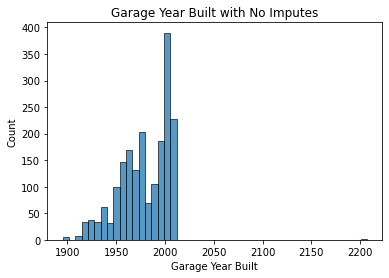

In [9]:
# Plotting the distribution of my Garage Year Built feature

sns.histplot(data=train, x='garage_yr_blt')
plt.title('Garage Year Built with No Imputes')
plt.xlabel('Garage Year Built')
plt.savefig('../figures/nul_garage_year_built.png', format='png');

##### There is an outlier that is skewing this data. The garage year built should not exceed the maximum year built. 

#### Imputing Values for Null and Nonsensical Outlier Values in Garage Year Built

![Outliers](../figures/impute_median_outlier_garage_year_built.png)

Once I impute the median for the nonsensical outlier garage year built, my distribution becomes more normal.


In [10]:
# This garage year built does not make sense (2207). 
# Replacing it with the median value because it the measure closer to the
#center of the normal distribution 

train[train['garage_yr_blt'] == train['garage_yr_blt'].max()]
train.loc[1699, 'garage_yr_blt'] = train['garage_yr_blt'].median()

### Mean or median for value imputed for null values 

![Null](../figures/impute_mean_garage_year_built.png) 

The mean value does not improve the quality of my distribution and is influenced by a few very low values. As a result, imputing the mean for my null values skews the distribution away from the appearance of the original distribution. The median might be a more useful imputed value.

In [11]:
# Imputing null values with median value because there is a significant outlier 
# in the garage year built that pulls the mean higher. The median is actually 
# the more accurate measure of central tendency because of this. 

train['garage_yr_blt'].fillna(train['garage_yr_blt'].median(), inplace=True)

In [12]:
# sns.histplot(data=train, x='garage_yr_blt')
# plt.title('Impute Median for Null Garage Year Built Values')
# plt.xlabel('Garage Year Built')
# plt.savefig('./figures/impute_median_garage_year_built.png', format='png');

By imputing the median, I am able to maintain the shape of the original distribution while filling the null values. 

### Outlier Identification within Numerical Values

* Outliers are identified with leveraged (AKA studentized) residuals post linear regression modeling. 
    * [Source: Introduction to Statistical Learning, pg 97](https://statlearning.com/ISLR%20Seventh%20Printing.pdf)
* The below figure displays studentized residuals vs the total predicted price. 
* There are 5 total outliers: points with studentized residuals greater than 6 or less than -6.
* The code for calculating outliers is shown below

### Code that calculated studentized residuals

```
# Predictors span the entire set of observations 
X_train_sm = sm.add_constant(X, prepend=True)

# Instantiating and fitting statsmodels ordinary least squares
lr_model = sm.OLS(y_log, X_train_sm).fit()

```
```
# Performing statsmodels outliers test, calculates leveraged (AKA studentized) residuals
outliers = lr_model.outlier_test()

# Gathering 5 largest outliers according to leveraged residuals
outliers['student_resid'].abs().sort_values(ascending=False).head(n=5)

# Calculating predicted prices for ordinary least squares
sm_pred_prices = np.exp(lr_model.predict(X_train_sm))
```

```
# Plotting leveraged residuals versus the predicted prices
student_res = outliers['student_resid']

# Most data points concentrated between -6 and 6 studentized residuals
# Outliers are thus greater than 6 or less than -5
plt.axhline(y=-6, color='red')
plt.axhline(y=6, color='red')
plt.scatter(x=sm_pred_prices, y=student_res)

plt.title('Outlier Identification')
plt.ylabel('Studentized Residuals')
plt.xlabel('Predicted Price')

plt.savefig('./figures/outlier_identification.png', format='png');
```
|Index|Studentized Residual(abs value)|
|---|---|
|960|16.898|
|1628|11.360|
|183|10.625|
|1885|10.481|
|952|6.635|

![Outliers](../figures/outlier_identification.png)

In [13]:
# Dropping outliers
train.drop([960,1628,183,1885, 952], inplace=True)

Now that I have identified outliers and imputed the median value for my garage year built null values, I can impute all other numerical feature null values with 0

In [14]:
# Imputing all other numerical nulls with 0 

train[numerical_columns] = train[numerical_columns].fillna(0)

### Predictor Relationship to Sale Price 

After identifying outliers, it is important to determine which numerical features have a linear relationship to Sale Price. Based on the distribution of sale price shown below, I also want to explore if a power transformation of Sale Price would lead to a more accurate model. 

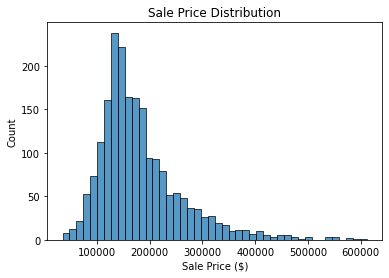

In [15]:
sns.histplot(data=train, x='saleprice')
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price ($)')
plt.savefig('../figures/sal_price_dis.png')

In [16]:
# low_r2 = r2_values[r2_values['r2'] < 0.25]['features'].to_list()

# intermediate_r2 = r2_values[(r2_values['r2'] >= 0.25) &
#                             (r2_values['r2'] < 0.4)]['features'].to_list()

# high_r2 = r2_values[r2_values['r2'] >= 0.4]['features'].to_list()

In [17]:
# Calculating the log(sale price) for every observation
train['log_saleprice'] = train['saleprice'].map(np.log)

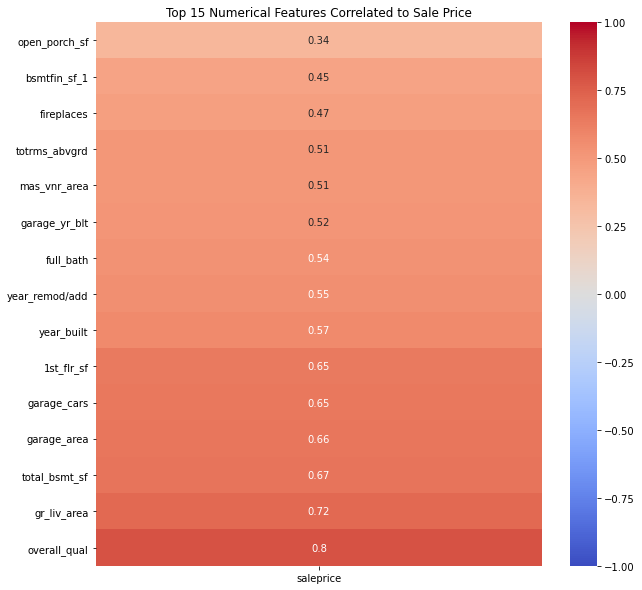

In [18]:
# Determining the 15 features most likely to have linear relationship to 
# Sale Price. Sale Price and log(Sale Price) are excluded 
plt.figure(figsize=(10,10))
sns.heatmap(train.corr()[['saleprice']].sort_values('saleprice')[23:38],
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            annot=True)
plt.title('Top 15 Numerical Features Correlated to Sale Price');

Top 15 features most likely to have a strong relationship with Sale Price. 

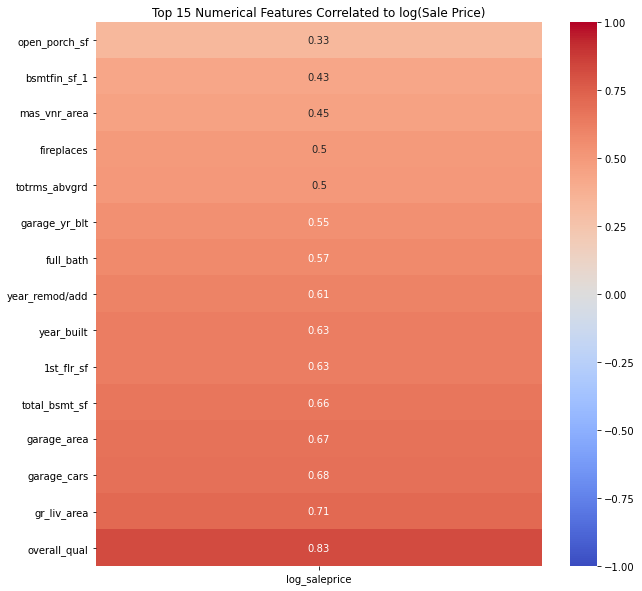

In [19]:
# Determining 15 features that have strongest relationship to log(Sale Price)
plt.figure(figsize=(10,10))
sns.heatmap(train.corr()[['log_saleprice']].sort_values('log_saleprice')[23:38],
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            annot=True)
plt.title('Top 15 Numerical Features Correlated to log(Sale Price)');

While the set of the top 15 features does not change, several feature's correlation coefficient changes enough that the features are re-ordered. Ultimately, does this power transformation improve the quality of our linear regression then? 

#### R2 Values improve when Sale Price is power transformed

In [20]:
# Source: https://stackoverflow.com/questions/60124004/creating-dataframe-on-the-basis-of-r-squared-value

# Dataframe of r2 values for each numerical feature with respect to sale price

r2_values = pd.DataFrame({'features': numerical_columns,
            'r2':[
            stats.linregress(train[[col,'saleprice']].to_numpy()).rvalue ** 2 
            for col in numerical_columns
                 ]
                         })
display(r2_values)

,features,r2
0,lot_frontage,0.034838
1,lot_area,0.092680
2,overall_qual,0.643977
3,overall_cond,0.010225
4,year_built,0.326926
5,year_remod/add,0.303036
6,mas_vnr_area,0.262315
7,bsmtfin_sf_1,0.199338
8,bsmtfin_sf_2,0.000259
9,bsmt_unf_sf,0.036483


In [21]:
# Assessing whether a power transformation of sale price improves the relationships
# to its numerical features. 
log_r2_values = pd.DataFrame({'features': numerical_columns,
            'r2':[
            stats.linregress(train[[col,'log_saleprice']].to_numpy()).rvalue ** 2 
            for col in numerical_columns
                 ]
                         })
display(log_r2_values)

,features,r2
0,lot_frontage,0.023536
1,lot_area,0.085574
2,overall_qual,0.681803
3,overall_cond,0.002416
4,year_built,0.397453
5,year_remod/add,0.366420
6,mas_vnr_area,0.206413
7,bsmtfin_sf_1,0.187138
8,bsmtfin_sf_2,0.000663
9,bsmt_unf_sf,0.038455


#### R2 Value Greater than 0.6

<Figure size 648x648 with 0 Axes>

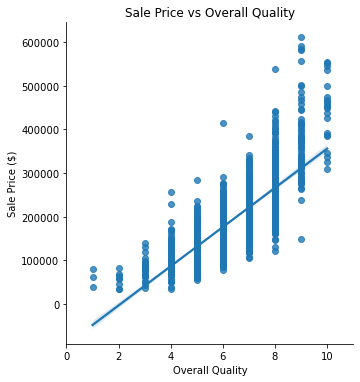

<Figure size 648x648 with 0 Axes>

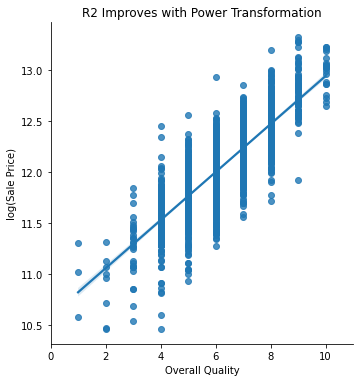

In [22]:
plt.figure(figsize=(9,9))
sns.lmplot(data=train, x='overall_qual', y='saleprice')
plt.xlim(0,11)
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price ($)')
plt.title('Sale Price vs Overall Quality');

plt.figure(figsize=(9,9))
sns.lmplot(data=train, x='overall_qual', y='log_saleprice')
plt.xlim(0,11)
plt.xlabel('Overall Quality')
plt.ylabel('log(Sale Price)')
plt.title('R2 Improves with Power Transformation');

The fit minimally improves the R2 of the feature with the highest R2 relative to Sale Price.

#### R2 Between  0.4 and 0.5

<Figure size 648x648 with 0 Axes>

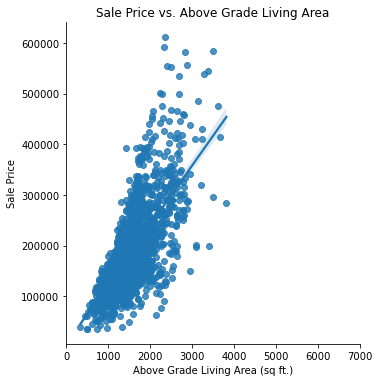

<Figure size 648x648 with 0 Axes>

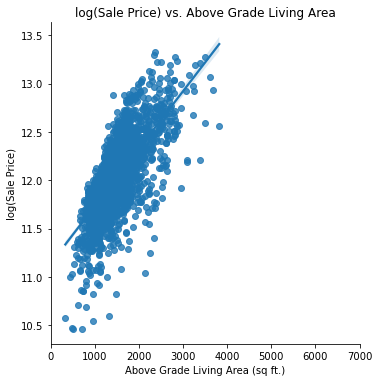

In [23]:
plt.figure(figsize=(9,9));
sns.lmplot(data=train, x='gr_liv_area', y='saleprice')
plt.xlim(0, 7000)
plt.ylabel('Sale Price')
plt.xlabel('Above Grade Living Area (sq ft.)')
plt.title('Sale Price vs. Above Grade Living Area');
           
plt.figure(figsize=(9,9));
sns.lmplot(data=train, x='gr_liv_area', y='log_saleprice')
plt.xlim(0, 7000)
plt.ylabel('log(Sale Price)')
plt.title('log(Sale Price) vs. Above Grade Living Area')
plt.xlabel('Above Grade Living Area (sq ft.)');

The 95% confidence interval (shaded region around the linear regression line) slightly improves with power transformation, however the R2 for this feature decrease by 0.01. Will this lower R2 affect the overall linear regression too much?

#### R2 Between 0.3 and 0.4

<Figure size 648x648 with 0 Axes>

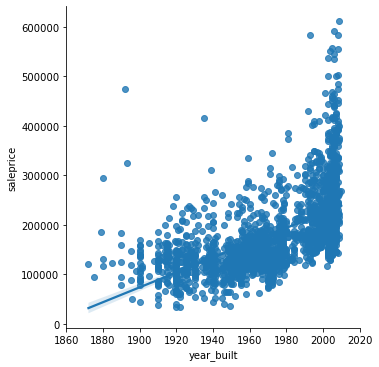

<Figure size 648x648 with 0 Axes>

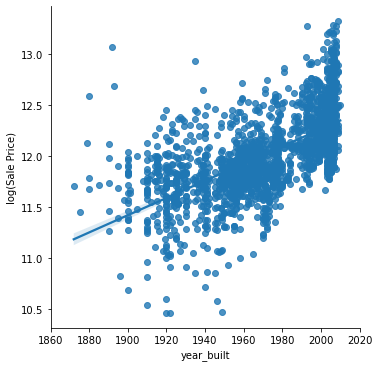

In [24]:
plt.figure(figsize=(9,9));

sns.lmplot(data=train, x='year_built', y='saleprice')
plt.xlim(1860, 2020);

plt.figure(figsize=(9,9));
sns.lmplot(data=train, x='year_built', y='log_saleprice')
plt.ylabel('log(Sale Price)')
plt.xlim(1860, 2020);

This plot in particular highlights how the power transformation of the sale price improves the predictive ability of independent variables that have a weaker R2 relative to Sale Price.  

#### R2 Between 0.2 and 0.3

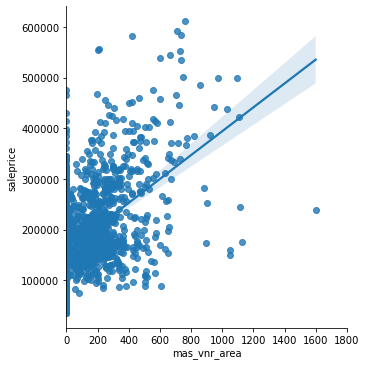

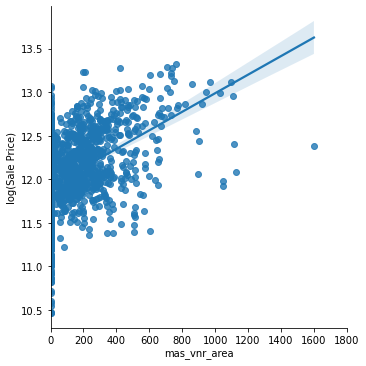

In [25]:
sns.lmplot(data=train, x='mas_vnr_area', y='saleprice')
plt.xlim(0, 1800);

sns.lmplot(data=train, x='mas_vnr_area', y='log_saleprice')
plt.xlim(0, 1800)
plt.ylabel('log(Sale Price)');

The R2 value actually decreases for this particular feature. My hypothesis that features with low R2 will have their R2 improved by the power transformation is not 100% accurate. Instead, it is dependent on the variable. 

#### R2 between 0 and 0.10

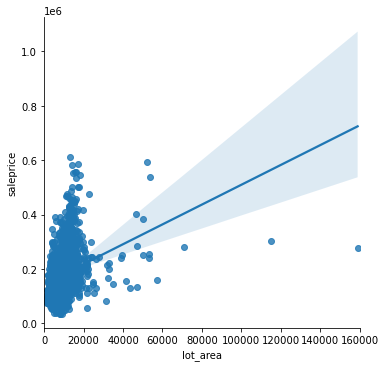

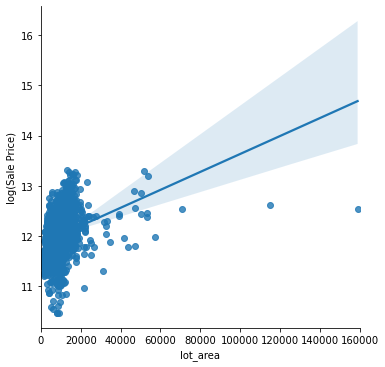

In [26]:
sns.lmplot(data=train, x='lot_area', y='saleprice');
plt.xlim(0, 160000)

sns.lmplot(data=train, x='lot_area', y='log_saleprice')
plt.xlim(0, 160000)
plt.ylabel('log(Sale Price)');

This plot confirms it: lower R2 values are not necessarily improved by power transformation. So then, will the cumulative R2 score improve with the log transformation or not?

In [27]:
sum(r2_values['r2'])

5.712075997032884

In [28]:
sum(log_r2_values['r2'])

5.939863960575037

### Relationship Analysis

* Power transformation of Sale Price makes linear regression model slightly more accurate with regard to the numerical features
    * While each feature differs slightly with regard to whether its r2 increases or decreases with power transformation, the overall R2 increases as shown by the cumulative R2 scores



### Numerical Predictor Summary Statistics

In [29]:
train[numerical_columns].describe()

,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
count,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000,2046.000000
mean,57.763930,10018.710166,6.111926,5.565005,1971.699902,1984.188172,97.880254,438.446725,48.052786,567.612414,1054.111926,1160.453079,329.669599,5.526393,1495.649071,0.426686,0.063050,1.577224,0.370479,2.845064,1.043011,6.431085,0.588954,1978.674487,1.774682,472.383675,93.586022,47.262463,22.544477,2.597752,16.551808,2.057674,43.391496,6.221896,2007.775171
std,32.652194,6610.202748,1.414796,1.102754,30.169414,21.033802,172.021682,439.845182,165.148546,445.184671,426.066473,377.573134,425.720830,51.130535,484.862732,0.521659,0.251029,0.549416,0.500941,0.826778,0.210036,1.544417,0.636045,24.184430,0.765749,214.698686,128.227713,65.888481,59.822335,25.260113,57.438484,35.978581,434.796744,2.742517,1.312453
min,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,43.000000,7500.000000,5.000000,5.000000,1954.000000,1964.250000,0.000000,0.000000,0.000000,220.000000,793.000000,880.000000,0.000000,0.000000,1130.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,63.000000,9400.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1092.500000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,26.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,78.000000,11500.000000,7.000000,6.000000,2001.000000,2004.000000,158.000000,733.000000,0.000000,811.000000,1317.750000,1403.750000,693.250000,0.000000,1728.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2188.000000,1474.000000,2336.000000,3206.000000,3820.000000,1862.000000,1064.000000,3820.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,14.000000,4.000000,2010.000000,5.000000,1356.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,12500.000000,12.000000,2010.000000


### Categorical and Ordinal Feature Cleaning

In [30]:
# Categorical datatypes are object datatypes minus the ordinal columns
string_feats = train.select_dtypes(object)
categorical_columns = string_feats.columns.to_list()

In [31]:
# There is one column that is an integer datatype that is actually a categorical variable: ms_subclass
# The integers in this column denote a particular building class rather than a continuous value

categorical_columns.append('ms_subclass')

#### One-hot encoding categorical features

In order to utilize the categorical data, it needs to be transformed into 
meaningful numerical information. To do this, I will one hot encode the categorical 
data through a two-step masking process. 

* In the first step, I will analyze whether the value for a given feature has enough meaningful data points to ensure that I will not be introducing unnecessary variance into my linear regression. I set the threshold for this at 100 total observations per value. 
* In the second step, I created 4 distinct sale price bins that allowed me to filter each value based on its mean sale price. By doing so, I was able to create some insight into how that particular value influences the sale price of a house. I then ensured that I did not create an empty dummy column in order to maintain the efficiency of my dummy columns. 

I maintained rank efficiency through this two-step process, ensuring that there was always at least one value from each feature that would not be found in any of the created dummy columns.

#### Ordinal features
Ordinal features are categorical features whose values have a hierarchical ordering. In the Ames Housing dataset, ordinal features include features measured by a scale of poor to excellent, such as exterior quality. One could quantify these values by ascribing the lowest value, in this case 'Po', to 1 and the highest value, 'Ex' for excellent, a 5 because there are 5 total rankings. The null values in this case would then be assigned to 0. However, we could also one hot encode these features so that each feature is indicative of a mean housing price, we just lose the ordering of the values. In this case, since we are binnning values based on their mean sale price, we can lose this information. 
 

In [32]:
def one_hot_encode(column_list):
    
    '''One hot encodes categorical features into 5 possible bins: one of the 
    150k, 200k, 250k, 300k sale bins or the dropped bin which includes values
    with not enough features to be included in one of the sale price bins. 
    ---
    Parameter:
    column_list: list of categorical columns to be one-hot encoded.'''
    
    # List of dummy columns created 
    dummy_columns = []
    columns_dummied = []
    
    for col in column_list:
    # Creates series of values in column with their sale price
        col_groupby = train.groupby(col)['saleprice']
        col_count_mean = col_groupby.agg(['count', 'mean'])
        
        
        # Ensures that sparse values are not included 
        col_counts = col_count_mean['count'] > 100
        if len(col_count_mean[col_counts]) < 2:
            continue
            
        
        # Sale price binning for each feature 
        # The price associated with the first 3 bins denotes the price to 
        # which the bin goes up to, wheras the last bin represents the values 
        # that round to 300k
        col_price_150k = col_count_mean['mean'] <= 150_000
        
        col_price_200k = ((col_count_mean['mean'] > 150_000) & 
                                (col_count_mean['mean'] <= 200_000))
        
        col_price_250k = ((col_count_mean['mean'] > 200_000) & 
                                (col_count_mean['mean'] <= 250_000))
        
        col_price_300k = col_count_mean['mean'] > 250_000
        
        
        # List of values in each feature that meet sale price conditions and count values
        col_150k_values = col_count_mean[(col_counts) & 
                                         (col_price_150k)].index.to_list()
        
        col_200k_values = col_count_mean[(col_counts) & 
                                         (col_price_200k)].index.to_list()
        
        col_250k_values = col_count_mean[(col_counts) & 
                                         (col_price_250k)].index.to_list()
        
        col_300k_values = col_count_mean[(col_counts) & 
                                         (col_price_300k)].index.to_list()
        
        
        # Masking train for dummy column creation
        col_150k_mask = train[col].isin(col_150k_values)
        col_200k_mask = train[col].isin(col_200k_values)
        col_250k_mask = train[col].isin(col_250k_values)
        col_300k_mask = train[col].isin(col_300k_values)
        
        # Getting base column name for dummy column creation 
        column_name = f'{col}'
        columns_dummied.append(column_name)
        
        columns_created = []
        
        # Creating dummy columns
        if sum(col_150k_mask) > 0:
            train[column_name + '_150k'] = col_150k_mask.astype(int)
            columns_created.append(column_name + '_150k')
        if sum(col_200k_mask) > 0:
            train[(column_name + '_200k')] = col_200k_mask.astype(int)
            columns_created.append(column_name + '_200k')
        if sum(col_250k_mask) > 0:
            train[(column_name + '_250k')] = col_250k_mask.astype(int)
            columns_created.append(column_name + '_250k')
        if sum(col_300k_mask) > 0:
            train[(column_name + '_300k')] = col_300k_mask.astype(int)
            columns_created.append(column_name + '_300k')
            
        
        # Filling null values with 0 
        train.loc[:, columns_created] = train[columns_created].fillna(0)
        
        # Adding dummy columns to dummy_column list
        dummy_columns += columns_created
        
    return (columns_dummied, dummy_columns)

categorical_cols = one_hot_encode(categorical_columns)

In [33]:
cat_features = pd.DataFrame({'Categorical_Features': categorical_cols[0]})
cat_features.to_csv('../datasets/output/categorical_features.csv')

#### Validity of this Approach for Categorical Features

To graphically show the validity of this approach, I plotted 7 neighborhood average selling prices. Amongst the neighborhoods chosen, the neighborhoods could fall in one of three bins: the up to 150k bin, the up to 250k  bin, or the dropped bin because the neighborhood does not have enough homes to make it past the observational threshold.

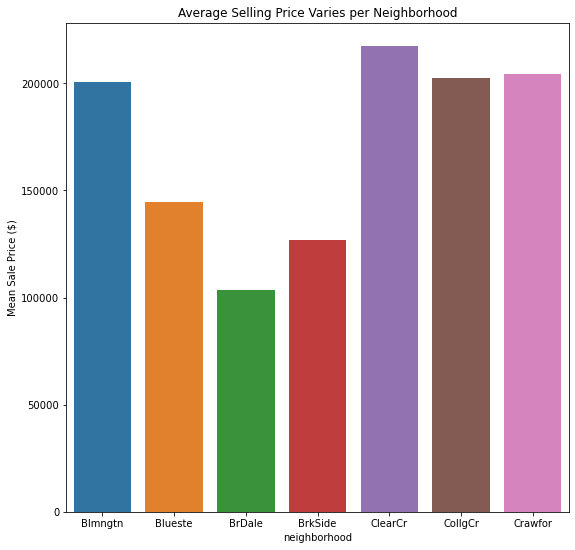

In [34]:
# Categorical variable binning based on sale price 
neighborhood_gb = train.groupby('neighborhood')['saleprice']
neighborhood_count_mean = neighborhood_gb.agg(['count','mean'])[:7]

plt.figure(figsize=(9,9))
sns.barplot(data=neighborhood_count_mean, x=neighborhood_count_mean.index, y='mean')
plt.ylabel('Mean Sale Price ($)')
plt.title('Average Selling Price Varies per Neighborhood');

#### Validity of this Approach for Ordinal Features

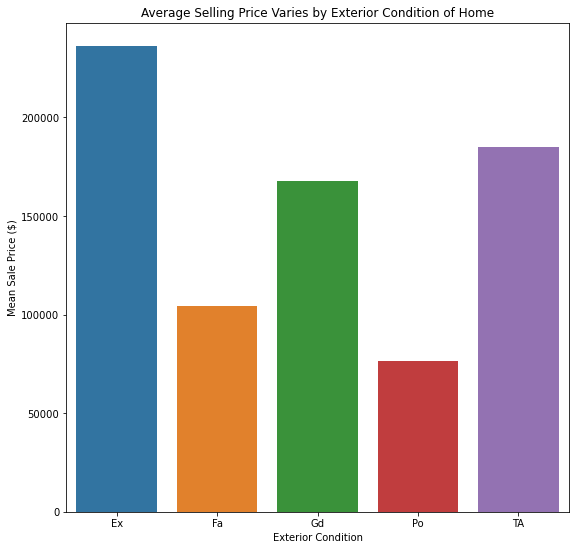

In [35]:
# Ordinal variable binning based on sale price 
exterior_cond_gb = train.groupby('exter_cond')['saleprice']
exterior_cond_count_mean = exterior_cond_gb.agg(['count','mean'])[:7]

plt.figure(figsize=(9,9))

sns.barplot(data=exterior_cond_count_mean, x=exterior_cond_count_mean.index, 
            y='mean')

plt.ylabel('Mean Sale Price ($)')
plt.xlabel('Exterior Condition')
plt.title('Average Selling Price Varies by Exterior Condition of Home')
plt.savefig('../figures/neighborhood_average_price.png');

In [36]:
train.to_csv('../datasets/output/train_clean.csv', index=False)

## Ability to Address Problem Statement

The thoroughness of the Ames Housing dataset allows me to construct numerical data to perform linear regression modeling. While 43 of the features are categorical by nature, I was able to transform these columns into meaningful data points utilizing one hot encoding and hierarchical data into an ordinal ranking. The next steps involve feature ranking, multicollinearity testing, and regularization in order to develop the most accurate model.